## Study of the score auto-calibration procedure used by HH-Suite

HHsearch/HHblits tools use extreme value distribution (EVD) model for deriving hit's $P{\text -}value$, $E{\text -}value$, and $Probability$ estimates from query-target local alignment similarity score:

$P_{value}(score) = 1 - exp(-exp(\lambda * (score - \mu)))$

HHsearch EVD parameters $\lambda$ and $\mu$ indirectly depend on the query and target lengths. Prior to HHsearch version 1.6.0, an empirical calibration of query and/or target HMM profiles was used for determining EVD $\lambda$ and $\mu$. This approach was justified by the statistics of scores for non-homologous sequences, which were obtained during the calibration step that was time-consuming. Starting from HHsearch version 1.6.0, $\lambda$ and $\mu$ an auto-calibration procedure was introduced &ndash; EVD parameters are now calculated from query and target profile lengths and diversities by two simple artificial neural networks, essentially two nonlinear functions. The parameters of these neural networks were derived by training process performed against a set of SCOP database profiles with objective to reproduce $\lambda$ and $\mu$ values obtained by the prior calibration procedure, see "3.5. P-value calculation with neural networks" section in {[Remmert, 2011](https://www.semanticscholar.org/paper/Fast%2C-sensitive-protein-sequence-searches-using-of-Remmert/393d2c27ee4db5973389ba28e2483f66a724f104)}. See HH-Suite [User Guide](https://github.com/soedinglab/hh-suite/wiki#dont-i-need-to-calibrate-my-query-or-database-hmm) for the description of this feature.

In HH-Suite v.2.x versions there was an option, "-calm", that enables manual calibration for backward compatibility with older versions. However in contemporary HH-Suite v.3.x versions this option was deleted.

HH-Suite auto-calibration feature was designed and tested with search queries and targets of size 80-300aa (median SCOP database item length is 142) which leaves some amount of uncertainty about its robustness outside this context.
For instance, hits that are obtained by too short or too long queries could be unfairly upvoted or downvoted, respectively. This notebook tries to reveal hidden properties of HH-Suite hit evaluation and assess its applicability in extreme cases.

_Note_: Use **Shift+Enter** to execute the code cells below. The order of execution is important (top to bottom).<br>
All the cells can be executed with **Kernel/Restart and Run all** menu command or **>>** toolbar button.<br>
When some cell is modified it should be re-executed (all the dependent cells might also need update, **Cell/Run All Below** menu command does this).<br>**Ctrl-Z** hotkey undoes cell changes.

In [1]:
import os
import sys
import csv
import math
import copy as cp
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.path import Path
import matplotlib.patches as patches
from cycler import cycler # for B/W theme
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '=.']) * cycler('marker', ['^',',', '.']))
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16,
       }
matplotlib.rc('font', **font)
savePDF=False

%matplotlib inline

The functions below were translated from C++ code of HH-Suite package.
The code looks a bit messy and lack proper documentation but it's exactly the code that was introduced in version 1.6.0 and hasn't been changed much since then.

Note, that the code corresponds only to local search mode of HHsearch tool (global search mode uses a bit different $Probability$ formula and HHblits tool reports $E{\text -}value$ which is also corrected by $E{\text -}value$ corresponding prefiltering step).

In [2]:
class Hit:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def __repr__(self):
        return str(self.__dict__)

def CalculatePvalues(h):
    """Calculates P-value, E-value, and Probability for the hit
    using Viterbi score, SS score, and EVD lamda/mu values
    obtained from query/template lengths and diversity values.
    """
    log1000 = math.log(1000.0)
    query_log_len = math.log(h.q_L)/log1000
    hit_log_len = math.log(h.t_L)/log1000
    h.lamda = lamda_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.mu = mu_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.logPval = logPvalue(h.score,h.lamda,h.mu)
    h.Pval = Pvalue(h.score,h.lamda,h.mu)
    h.Eval = math.exp(h.logPval + math.log(h.N_searched))
    h.logEval = h.logPval + math.log(h.N_searched)
    if h.logPval < -10.0:
        x = h.logPval
    else:
        x = math.log(-math.log(1-h.Pval))
    h.score_aass = x/0.45 - min(h.lamda*h.score_ss,max(0.0,0.2*(h.score-8.0)))/0.45 - 3.0
    h.Probab = Probab(-h.score_aass, h.score_ss != 0.0)

def calc_hidden_output(weights, bias, Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Calculate output of hidden neural network units"
    # Calculate activation of hidden unit = sum of all inputs * weights + bias
    res = Lqnorm*weights[0] + Ltnorm*weights[1] + Nqnorm*weights[2] + Ntnorm*weights[3] + bias
    res = 1.0 / (1.0 + math.exp(-(res))) # logistic function
    return res

def lamda_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of lamda for EVD"
    inputs = 4
    hidden = 4
    biases = [-0.73195, -1.43792, -1.18839, -3.01141] # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
        -0.52356, -3.37650, 1.12984, -0.46796,
        -4.71361, 0.14166, 1.66807, 0.16383,
        -0.94895, -1.24358, -1.20293, 0.95434,
        -0.00318, 0.53022, -0.04914, -0.77046,
        2.45630, 3.02905, 2.53803, 2.64379
    ]
    lamda=0.0
    for h in range(hidden):
        lamda += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return lamda

def mu_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of mu for EVD"
    inputs = 4
    hidden = 6
    biases = [-4.25264, -3.63484, -5.86653, -4.78472, -2.76356, -2.21580]  # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
        1.96172, 1.07181, -7.41256, 0.26471,
        0.84643, 1.46777, -1.04800, -0.51425,
        1.42697, 1.99927, 0.64647, 0.27834,
        1.34216, 1.64064, 0.35538, -8.08311,
        2.30046, 1.31700, -0.46435, -0.46803,
        0.90090, -3.53067, 0.59212, 1.47503,
        -1.26036, 1.52812, 1.58413, -1.90409, 0.92803, -0.66871
    ]
    mu=0.0
    for h in range(hidden):
        mu += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return 20.0*mu

def Pvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return math.exp(-h)
    else:
        return 1.0 - math.exp(-math.exp(-h))

def logPvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return -h
    else:
        if h < -2.5:
            return -math.exp(-math.exp(-h))
        else:
            return math.log((1.0 - math.exp(-math.exp(-h))))

def Probab(s, has_ss):
    """
    Calculate probability of true positive : p_TP(score)/( p_TP(score)+p_FP(score) )
    TP: same superfamily OR MAXSUB score >=0.1
    """
    if s > 200:
        return 100.0
    if has_ss:
        # local with SS
        a=math.sqrt(6000.0)
        b=2.0*2.5
        c=math.sqrt(0.12)
        d=2.0*32.0
    else:
        # local no SS
        a=math.sqrt(4000.0)
        b=2.0*2.5
        c=math.sqrt(0.15)
        d=2.0*34.0
    t = a*math.exp(-s/b) + c*math.exp(-s/d)
    return 100.0/(1.0+t*t) # ??? JS Jul'12

Below is the set of hits taken from HHsearch output files (query and target profiles' diversity, Neff, can be found in the header of HMM file).<br>
The Example 4.1 with precise $Score$, $P{\text -}value$, and $Probability$ values was obtained from specially modified HHsearch version.

In [3]:
test_cases = [
    {'name': 'Example 1',
     'file': 'YP_009179227.1-PF08301.12',
     'comment': 'It has the highest probability gain due to large query length decrease'
    },
    {'name': 'Example 2',
     'file': 'YP_009388303.1-PF13238.5',
     'comment': 'It shows high probability gain in spite of smaller decrease of the query length (high target profile diversity, Neff=11.5)'
    },
    {'name': 'Example 3',
     'file': 'YP_004070193.2-PF14519.5',
     'comment': 'It shows low probability gain in spite of large query length decrease (it has high score, thus the Probability for iteration #1 is already high)',
     'figure6': 'Note: Visible deviation of P-value estimation for LAMPA case is explained by score decrease (shorter query profile has different background aa frequencies, see default "-sc 1" option)'
    },
    {'name': 'Example 4',
     'file': 'NP_690588.1-PF01728.18',
     'comment': 'Another example with high target profile diversity (Neff=11.7)'
    },
    # Hits can be described explicitly here (e.g. with more precise score, ss_score, and other values,
    # obtained from modified version of HHsearch):
    {'name': 'Example 4.1',
     'comment': 'High precision version of Example 4',
     'hits': [
        # NP_690588.1_1-2474 vs. PF01728.18 (iteration_1)
        Hit(score=40.7270432, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=2474, t_L=183, N_searched=1,
            Probab_HH=77.7733154, Pval_HH=1.50802e-05, query='NP_690588.1', query_coords='1-2474',
            target='PF01728.18', iteration='1', comment='HHsearch'),
        # NP_690588.1_1166-1348 vs. PF01728.18 (iteration_2)
        Hit(score=39.3617821, score_ss=-0.0733758, q_Neff=1.0, t_Neff=11.7, q_L=(1348-1166+1), t_L=183, N_searched=1,
            Probab_HH=95.1556091, Pval_HH=1.15029e-07, query='NP_690588.1', query_coords='1166-1348',
            target='PF01728.18', iteration='2', comment='LAMPA')
        ],
    },
]

hits = []

def getHits(item):
    global hits
    if 'hits' in item:
        hits = item['hits']
    elif 'file' in item:
        with open('input/' + item['file'] + '.csv') as f:
            csv_reader = csv.reader(f)
            hits = []
            for r in csv_reader:
                if r[0] == 'Query':
                    continue
                if r[4] == 'iteration #1':
                    r[4] = 'HHsearch'
                else:
                    r[4] = 'LAMPA'
                h = Hit(
                    query=r[0],
                    query_coords=r[1],
                    target=r[2],
                    iteration=r[3],
                    comment=r[4],
                    Probab_HH=float(r[5]),
                    Pval_HH=float(r[6]),
                    score=float(r[7]),
                    score_ss=float(r[8]),
                    q_L=int(r[9]),
                    t_L=int(r[10]),
                    q_Neff=float(r[11]),
                    t_Neff=float(r[12]),
                    N_searched=1,
                   )
                hits.append(h)

def printHits(item, hits, comment='comment', short=False):
    name = hits[0].query + '-' + hits[0].target
    print('')
    print(item['name'], ', ', name, sep='')
    if comment in item:
        print('')
        print(item[comment])
    if short:
        for i, h in enumerate(hits):
            CalculatePvalues(h)
        return
    print('')
    print('')
    for i, h in enumerate(hits):
        CalculatePvalues(h)
        print('')
        if i == 0:
            print('Iteration #1 or "HHsearch" hit (long query, low Probability):')
        else:
            print('Iteration #2 or "LAMPA" hit (short query, high Probability):')
        print('')
        print('Query length:', h.q_L)
        print('HHsearch Probability: ', h.Probab_HH, '%', sep='')
        print('HHsearch P-value:', h.Pval_HH)
        print('Score:', h.score)
        print('SS Score:', h.score_ss)
        print('Target profile diversity, Neff:', h.t_Neff)
        print('Calculated Probability: ', h.Probab, '%', sep='')
        print('Calculated P-value:', h.Pval)
        # print('Calculated score_aass:', h.score_aass)
        # print('Calculated lamda:', h.lamda)
        # print('Calculated mu:', h.mu)
        print('')

@interact
def showExample(Name=[x['name'] for x in test_cases]):
    item = next(x for x in test_cases if x['name'] == Name)
    getHits(item)
    printHits(item, hits)

interactive(children=(Dropdown(description='Name', options=('Example 1', 'Example 2', 'Example 3', 'Example 4'…

The above P-value and Probability values match, it confirms that this calculation is correct (see the relative error $\approx 10^{-6}$ for Example 4.1 where precise HHsearch score and probability are known).

### P-value and Probability as functions of query and target lengths

In [4]:
def modelLengths(X, type='query'):
    Prob_A = X.copy()
    Pval_A = X.copy()
    for i, x in enumerate(X):
        h = cp.copy(hits[0])
        if type == 'query':
            h.q_L = x
        elif type == 'target':
            h.t_L = x
        CalculatePvalues(h)
        Pval_A[i] = h.Pval
        Prob_A[i] = h.Probab
    return [Prob_A, Pval_A]

def plotPvalProbByLengths(hits):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_prop_cycle(monochrome)
    ax2.set_prop_cycle(monochrome)
    fig.set_size_inches(7,11)

    X = np.logspace(1, 6, num=51, base=10)
    QProb, QPval = modelLengths(X, 'query')
    TProb, TPval = modelLengths(X, 'target')

    color = next(ax1._get_lines.prop_cycler)['color']
    markers = ['D', 'o', 'x', '+']

    ax1.loglog(X, QPval, marker='o', markersize=3, linestyle='', label='query', c=color)
    ax1.loglog(X, TPval, marker='x', markersize=5, linestyle='', label='target')
    # ax1.plot(X, [hits[0].Pval] * len(X), '-', zorder=0, label='original P-value')

    for (i, h) in enumerate(hits):
        ax1.scatter([h.q_L], [h.Pval], zorder=4, label=h.comment, marker=markers[i], c=color, s=64)

    ax1.set_ylabel('P-value', size=16);
    ax1.legend(prop={'size': 11})
    ax1.grid(True)
    ax1.set_xlabel('L, query or target length', size=16)
    ax1.xaxis.set_tick_params(which='both', labelbottom=True)

    color = next(ax2._get_lines.prop_cycler)['color']
    ax2.semilogx(X, QProb, marker='o', markersize=3, linestyle='', label='query', c=color)
    ax2.semilogx(X, TProb, marker='x', markersize=5, linestyle='', label='target')
    # ax2.plot(X, [hits[0].Probab] * len(X), '-', zorder=0, label='original probability')
    ax2.plot(X, [95] * len(X), '-', zorder=0, label='95% threshold') # c='red'

    for (i, h) in enumerate(hits):
        ax2.scatter([h.q_L], [h.Probab], zorder=4, label=h.comment, marker=markers[i], c=color, s=64)

    ax2.set_ylabel('Probability', size=16);
    ax2.legend(prop={'size': 12})
    ax2.grid(True)
    # ax2.set_title('B', weight=800, size=16, loc='left')
    pair_name = hits[0].query + '-' + hits[0].target
    ax2.set_xlabel('L, query or target length\n\n\n' + pair_name, size=16)

    plt.subplots_adjust(hspace=0.3, right=.99, left=0.145, top=0.99, bottom=0.15)
    pdffile = 'output/{}-{}-Figure-6.pdf'.format(hits[0].query, hits[0].target)
    if savePDF:
        plt.savefig(pdffile, format='PDF')
    # print(hits[0].query, 'vs.', hits[0].target)

In [5]:
@interact
def plotFigure6(Test=[x['name'] for x in test_cases]):
    item = next(x for x in test_cases if x['name'] == Test)
    getHits(item)
    printHits(item, hits, short=True, comment='figure6')
    plotPvalProbByLengths(hits)

interactive(children=(Dropdown(description='Test', options=('Example 1', 'Example 2', 'Example 3', 'Example 4'…

### Probability as a function of query and target lengths and diversities

Now let's make 2D contour plot for Probability vs. query/traget profile lengths and diversities.

In [6]:
def model2D(Q, T, hit, type='length'):
    X,Y = np.meshgrid(Q, T, indexing='ij')
    Z = X.copy()
    h = cp.copy(hit)
    for i, x in enumerate(Q):
        for j, y in enumerate(T):
            if type == 'length':
                h.q_L = x
                h.t_L = y
            elif type == 'Neff':
                h.q_Neff = x
                h.t_Neff = y
            CalculatePvalues(h)
            Z[i, j] = h.Probab
    return [X, Y, Z]


def plotContours(hit):
    q_len = np.logspace(1, 5, 41, base=10)
    t_len = np.logspace(1, 5, 41, base=10)
    X0, Y0, P0 = model2D(q_len, t_len, hit, 'length')

    q_neff = np.linspace(1, 15, 43)
    t_neff = np.linspace(1, 15, 43)
    X, Y, P = model2D(q_neff, t_neff, hit, 'Neff')

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(6,12.8)

    ax1.set_xscale("log", nonposx='clip')
    ax1.set_yscale("log", nonposy='clip')
    ax1.set_title('Score = ' + ('%4.1f' % hit.score) + ', Query/Target $N_{eff}\ =' + str(hit.q_Neff) + '/' + str(hit.t_Neff) + '$', size=14)
    ax1.set_xlabel('Query length', size=16)
    ax1.set_ylabel('Target length', size=16)

    levels = np.arange(0, 100, 5)

    p = ax1.contour(X0, Y0, P0, levels=levels, colors='k')
    ax1.clabel(p, levels[1::2], inline=1, fmt='%2.0f%%', fontsize=10)
    ax1.plot([hits[0].q_L], [hits[0].t_L], zorder=4, linestyle='', label='HHsearch', marker='D', c='black', markersize=8) # c=color
    ax1.plot([hits[1].q_L], [hits[1].t_L], zorder=4, linestyle='', label='LAMPA', marker='o', c='black', markersize=8)

    ax1.grid(True)
    ax1.legend() # prop={'size': 12}

    pair_name = hits[0].query + '-' + hits[0].target
    ax2.set_title('Score = ' + ('%4.1f' % hit.score) + ', Query/Target lengths =' + str(hit.q_L) + '/' + str(hit.t_L), size=14)
    ax2.set_xlabel('Query $N_{eff}$\n\n' + pair_name, size=16)
    ax2.set_ylabel('Target $N_{eff}$', size=16)

    levels = np.arange(0, 100, 5)
    p = ax2.contour(X, Y, P, levels=levels, colors='k')
    plt.xlim(left=0)
    plt.xticks(range(1, 17, 2))
    plt.yticks(range(1, 17, 2))
    plt.ylim(bottom=0)
    ax2.clabel(p, levels[0::1], inline=1, fmt='%2.0f%%', fontsize=10)

    ax2.plot([hit.q_Neff], [hit.t_Neff], zorder=4, linestyle='', label='HHsearch', marker='D', c='black', markersize=8) # c=color

    ax2.legend()
    ax2.grid(True)

    plt.subplots_adjust(hspace=0.23, top=0.98, right=0.95, left=0.13)
    pdffile = 'output/{}-{}-Figure-7.pdf'.format(hits[0].query, hits[0].target)
    if savePDF:
        plt.savefig(pdffile, format='PDF')

In [7]:
@interact
def plotFigure7(Test=[x['name'] for x in test_cases]):
    item = next(x for x in test_cases if x['name'] == Test)
    getHits(item)
    printHits(item, hits, short=True, comment='figure7')
    plotContours(hits[0])

interactive(children=(Dropdown(description='Test', options=('Example 1', 'Example 2', 'Example 3', 'Example 4'…

### Min. query length that generates Probability = 95% for a given score

These calculations adress our concerns about up-voting of the hits for short query and target profiles.<br>
See the figure below, after two code cells.

In [8]:
def findQLenForProbab(score, probab, t_len=None, t_neff=None):
    """
    Binary search for the query length that gives specified probability value
    """
    a = 0
    b = 1000000
    count = 0
    while a < b and count < 30:
        count += 1
        c = (a + b) / 2
        h = cp.copy(hits[0])
        h.score = score
        h.score_ss = 0
        h.q_L = c
        if t_len is not None:
            h.t_L = t_len
        if t_neff is not None:
            h.t_Neff = t_neff
        try:
            CalculatePvalues(h)
        except ValueError:
            # print("ValueError:", h.q_L, h.score, h.lamda, h.mu, file=sys.stderr)
            h.Pval = 1
            h.logPval = 0
            h.Probab = 0

        if h.Probab > probab:
            a = c
        else:
            b = c
    return int(a + 0.5)
    
def testScores(Z, probab=95, t_len=None, t_neff=None):
    for i, s in enumerate(S):
        Z[i] = findQLenForProbab(s, probab, t_len, t_neff)

# scores
S = np.linspace(1, 100, num=100)
QL_T132_NE6 = np.zeros(len(S), dtype=np.int)
QL_T50_NE6 = np.zeros(len(S), dtype=np.int)
QL_T132_NE15 = np.zeros(len(S), dtype=np.int)
QL_T50_NE15 = np.zeros(len(S), dtype=np.int)

# PfamA profile lengths: median=132, mean=176; N_eff: median=6.5, mean=6.55, min=1.0, max=15.8
testScores(QL_T132_NE6, 95, 132, 6.5)
testScores(QL_T50_NE6, 95, 50, 6.5)
testScores(QL_T132_NE15, 95, 132, 15)
testScores(QL_T50_NE15, 95, 50, 15)

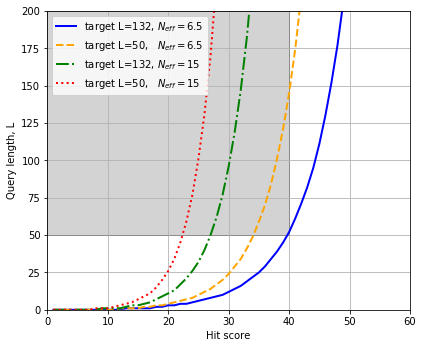

In [9]:
verts = [
    (0, 50),
    (40., 50),
    (40., 200.),
    (0, 200.),
    (0, 50)
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)

fig, ax = plt.subplots()
fig.set_size_inches(6.5,5.5)
plt.plot(S, QL_T132_NE6, label='target L=132, $N_{eff}=6.5$', color='blue', marker='', linestyle='-', linewidth=2)
plt.plot(S, QL_T50_NE6, label='target L=50,   $N_{eff}=6.5$', color='orange', marker='', linestyle='--', linewidth=2)
plt.plot(S, QL_T132_NE15, label='target L=132, $N_{eff}=15$', color='green', marker='', linestyle='-.', linewidth=2)
plt.plot(S, QL_T50_NE15, label='target L=50,   $N_{eff}=15$', color='red', marker='', linestyle=':', linewidth=2)

plt.xlabel('Hit score')
plt.ylabel('Query length, L')

plt.title("")

patch = patches.PathPatch(path, facecolor='lightgray', lw=1)
ax.add_patch(patch)


plt.legend()
plt.ylim(0, 200)
plt.xlim(0, 60)
ax.grid(True)
if savePDF:
    plt.savefig('output/Figure-N5.pdf', format='PDF')

This figure shows max. query length that gives Probability=95% for a given score, target length ($L$) and target sequence diversity ($N_{eff}$). Gray rectangle shows area of FP hits of min. length 50aa if max. false positive score is 40.0 (supposedly). Therefore the gray area under the lines presents possibilities for false hits with Probability > 95%. PfamA database has median profile length 132aa and diversity $N_{eff}=6.5$ (min. $N_{eff}=1.0$, max. $N_{eff}=15$). It follows that there is no gray area under the target $L=132aa$, $N_{eff}=6.5$. However, for shorter targets ($L=50aa$) and/or target profiles with higher diversity ($N_{eff}=6.5..15$) false hits with scores as low as 23.0 could be attributed with probability >95%.

Straightforward check for the Probability=95% cases:

In [10]:
# test_hit = Hit(score=39.0, score_ss=0, q_Neff=1.0, t_Neff=6.5, q_L=45, t_L=132, N_searched=1)
# test_hit = Hit(score=20.0, score_ss=0, q_Neff=1.0, t_Neff=15, q_L=25, t_L=50, N_searched=1)
test_hit = Hit(score=23.0, score_ss=0, q_Neff=1.0, t_Neff=15, q_L=50, t_L=50, N_searched=1)
CalculatePvalues(test_hit)
print(test_hit)

{'score': 23.0, 'score_ss': 0, 'q_Neff': 1.0, 't_Neff': 15, 'q_L': 50, 't_L': 50, 'N_searched': 1, 'lamda': 0.8281435009894186, 'mu': 1.7486599093904132, 'logPval': -17.599159183354214, 'Pval': 2.2739571702268868e-08, 'Eval': 2.2739571702268868e-08, 'logEval': -17.599159183354214, 'score_aass': -42.10924262967603, 'Probab': 95.28633201048132}
